from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import pandas as pd
from pyspark import SparkContext
from sklearn.ensemble import RandomForestRegressor
import pickle
import altair as alt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# Imports

In [148]:
pip install mapclassify

Note: you may need to restart the kernel to use updated packages.


## Libraries

In [164]:
import shapefile
import geopandas
import unidecode
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from mapclassify import Quantiles

## Data

In [2]:
pct_df = pd.read_csv("./my_saved_data/final_nyc_chi_dal_sf_df.csv", index_col=0)

<IPython.core.display.Javascript object>

In [3]:
pct_df.head(2)

,index,NYC,Chi,Dal,SF
0,Aguascalientes,0.01,0.0,0.00,0.00
1,Baja California,0.07,0.0,0.02,0.04


In [101]:
pct_df[pct_df['index'] == 'Puebla']

,index,NYC,Chi,Dal,SF
20,Puebla,0.37,0.0,0.01,0.0


In [4]:
with open("./my_saved_data/restaurant_counts.pickle", "rb+") as f:
    rest_counts = pickle.load(f)

<IPython.core.display.Javascript object>

In [5]:
rest_counts

{'NYC': 20, 'Chi': 5, 'Dal': 27, 'SF': 14}

In [6]:
all_df = pd.read_csv("./my_saved_data/Final_restaurant_list.csv", index_col=0)

<IPython.core.display.Javascript object>

In [7]:
all_df.head(2)

,City,Match,Region
chilango,Chicago,chilango,Ciudad de Mexico
los alamos,Chicago,alamos,Tabasco


# EDA

In [8]:
pct_df.sort_values(by=['NYC'], ascending=False)[0:5]

,index,NYC,Chi,Dal,SF
20,Puebla,0.37,0.0,0.01,0.00
29,Yucatan,0.13,0.0,0.04,0.11
5,Chihuahua,0.07,0.0,0.01,0.07
1,Baja California,0.07,0.0,0.02,0.04
19,Oaxaca,0.05,0.0,0.01,0.02


In [9]:
pct_df.sort_values(by=['Chi'], ascending=False)[0:5]

,index,NYC,Chi,Dal,SF
12,Jalisco,0.02,0.29,0.04,0.02
15,Michoacan de Ocampo,0.00,0.14,0.21,0.00
6,Ciudad de Mexico,0.00,0.14,0.01,0.00
25,Tabasco,0.01,0.14,0.04,0.04
10,Guerrero,0.02,0.14,0.07,0.04


In [10]:
pct_df.sort_values(by=['Dal'], ascending=False)[0:5]

,index,NYC,Chi,Dal,SF
15,Michoacan de Ocampo,0.00,0.14,0.21,0.00
3,Campeche,0.00,0.00,0.10,0.04
28,Veracruz,0.03,0.00,0.09,0.04
10,Guerrero,0.02,0.14,0.07,0.04
11,Hidalgo,0.02,0.00,0.06,0.00


In [11]:
pct_df.sort_values(by=['SF'], ascending=False)[0:5]

,index,NYC,Chi,Dal,SF
9,Guanajuato,0.00,0.0,0.01,0.40
29,Yucatan,0.13,0.0,0.04,0.11
5,Chihuahua,0.07,0.0,0.01,0.07
13,Mexico,0.01,0.0,0.05,0.07
3,Campeche,0.00,0.0,0.10,0.04


## How much overlap is there in the major regions for each group?

In [12]:
nyc_top5 = list(pct_df.sort_values(by=['NYC'], ascending=False)[0:5]['index'])

In [13]:
chi_top5 = list(pct_df.sort_values(by=['Chi'], ascending=False)[0:5]['index'])

In [14]:
dal_top5 = list(pct_df.sort_values(by=['Dal'], ascending=False)[0:5]['index'])

In [15]:
sf_top5 =list(pct_df.sort_values(by=['SF'], ascending=False)[0:5]['index'])

In [16]:
print(nyc_top5)
print(chi_top5)
print(dal_top5)
print(sf_top5)

['Puebla', 'Yucatan', 'Chihuahua', 'Baja California', 'Oaxaca']
['Jalisco', 'Michoacan de Ocampo', 'Ciudad de Mexico', 'Tabasco', 'Guerrero']
['Michoacan de Ocampo', 'Campeche', 'Veracruz', 'Guerrero', 'Hidalgo']
['Guanajuato', 'Yucatan', 'Chihuahua', 'Mexico', 'Campeche']


In [17]:
top5_region_dict = {y:0 for x in [nyc_top5, chi_top5, dal_top5, sf_top5] for y in x}

In [18]:
for sublist in [nyc_top5, chi_top5, dal_top5, sf_top5]:
    for region in sublist:
        for key, value in top5_region_dict.items():
            if region == key:
                top5_region_dict[key] += 1

In [102]:
# top5_region_dict

In [20]:
# only showing the most common regions
top5_more_than_2_list = []
for key, value in top5_region_dict.items():
    if value >= 2:
        top5_more_than_2_list.append(key)

In [21]:
top5_more_than_2_list

['Yucatan', 'Chihuahua', 'Michoacan de Ocampo', 'Guerrero', 'Campeche']

# Displaying Data

## Shapefile for mexico regions
https://geodata.lib.berkeley.edu/catalog/stanford-fs602xc1533

In [22]:
sf = shapefile.Reader("./data/MEX_adm1.shp")

In [23]:
states = [x[4] for x in sf.records()]

In [24]:
states[0:2]

['Aguascalientes', 'Baja California Sur']

In [25]:
state_shape_zip = dict(zip(states, sf.shapes()))

In [26]:
list(state_shape_zip.items())[0:2]

[('Aguascalientes', <shapefile.Shape at 0x11fcc1278>),
 ('Baja California Sur', <shapefile.Shape at 0x11fcc1518>)]

In [27]:
state_shape_df = pd.DataFrame.from_dict(state_shape_zip, orient='index')

<IPython.core.display.Javascript object>

In [28]:
state_shape_df.columns = ['geometry']

## Geodataframe

In [29]:
mex_gdf = geopandas.read_file("./data/MEX_adm1.shp")

In [30]:
mex_gdf.plot()

### Removing Unnecessary columns

In [31]:
mex_gdf.columns

Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'HASC_1', 'CCN_1', 'CCA_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1', 'geometry'],
      dtype='object')

In [32]:
mex_gdf.drop(columns = ['ID_0', 'ID_1', 'ISO', 'NAME_0', 'HASC_1', 'CCN_1', 'CCA_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1'], inplace=True)

In [50]:
regions = [unidecode.unidecode(x) for x in mex_gdf['NAME_1']]

In [51]:
mex_gdf['Region'] = regions

### Adding pct_df data

In [34]:
# which regions are missing in pct_df 

In [40]:
pct_df_names = list(pct_df['index'])

In [47]:
len(pct_df_names)

29

In [57]:
# pct_df_names

In [52]:
# truly missing regions are: queretaro, coahuila, quintana roo
for x in regions:
    if x not in pct_df_names:
        print(x)

Coahuila
Distrito Federal
Michoacan
Queretaro
Quintana Roo


#### Renaming 2 regions in pct_df

In [56]:
pct_df['index'][6] = 'Distrito Federal'
pct_df['index'][15] = 'Michoacan'

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Joining the two 

In [60]:
mex_gdf2 = mex_gdf.merge(pct_df, left_on = 'Region', right_on = 'index', how='outer')

In [62]:
mex_gdf2.fillna(value = 0, inplace=True)

In [63]:
mex_gdf2.head(2)

,NAME_1,geometry,Region,index,NYC,Chi,Dal,SF
0,Aguascalientes,"POLYGON ((-102.12611 21.73960, -102.13392 21.7...",Aguascalientes,Aguascalientes,0.01,0.0,0.00,0.0
1,Baja California Sur,"MULTIPOLYGON (((-114.75681 18.37097, -114.7568...",Baja California Sur,Baja California Sur,0.01,0.0,0.02,0.0


## Choropleth maps
consistent scale: https://github.com/geopandas/geopandas/issues/1019

### Consistent scale

In [183]:
bin_range_times10 = list(range(0, 5))

In [184]:
bin_range = np.array(bin_range_times10) / 10

In [185]:
bin_range

array([0. , 0.1, 0.2, 0.3, 0.4])

In [178]:
bins_2 = np.array(0, 0.1, 0.2, 0.3, 0.4)

ValueError: only 2 non-keyword arguments accepted

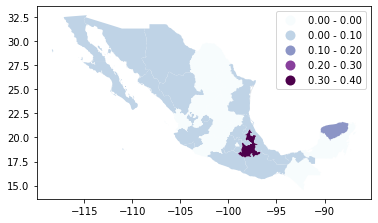

In [192]:
# NYC 
mex_gdf2.plot(column='NYC', legend=True, cmap='BuPu', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

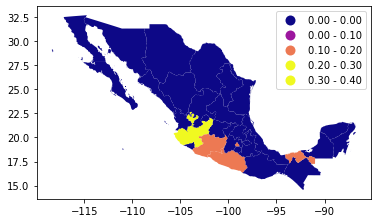

In [193]:
# chicago
mex_gdf2.plot(column='Chi', legend=True, cmap = 'plasma',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

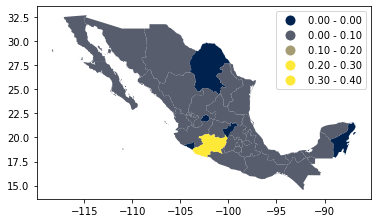

In [194]:
# dal
mex_gdf2.plot(column='Dal', legend=True, cmap = 'cividis',
              scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
#              legend_kwds={'label': "Percent of Matching Restaurants from This Region", 
#                           'orientation': "horizontal"})

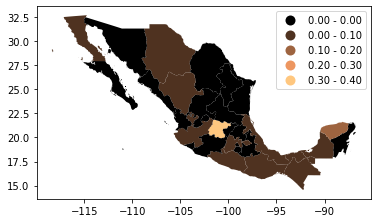

In [195]:
# sf
mex_gdf2.plot(column='SF', legend=True, cmap = 'copper',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

### Plotting all cities together
multiple axes: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

<IPython.core.display.Javascript object>

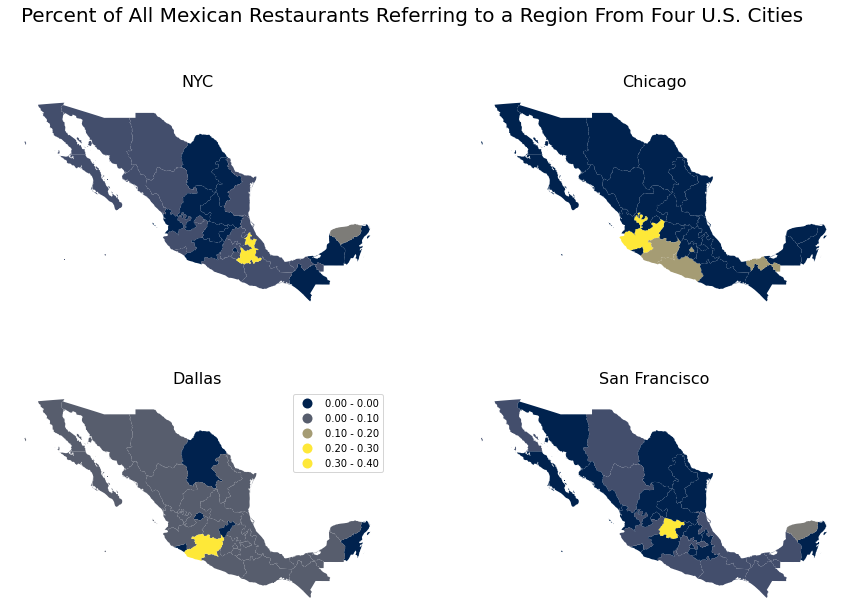

In [223]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
mex_gdf2.plot(
    column='NYC', ax=ax1, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax1.set_title('NYC', fontsize=16)
mex_gdf2.plot(
    column='Chi', ax=ax2, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax2.set_title('Chicago', fontsize=16)
mex_gdf2.plot(
    column='Dal', ax=ax3,  cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range), legend=True)
ax3.set_title('Dallas', fontsize=16)
mex_gdf2.plot(
    column='SF', ax=ax4,cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax4.set_title('San Francisco', fontsize=16)
for ax in (ax1,ax2,ax3,ax4,):
    ax.axis('off')

## Percent of Restaurants that Have a Region Associated With Them

In [256]:
#NYC had 849 unique mexican restaurants, 20 matched
print(f"The percent of restaurants that had a name attached to a region was {round(86/849, 2) * 100}%")

The percent of restaurants that had a name attached to a region was 10.0%


<IPython.core.display.Javascript object>

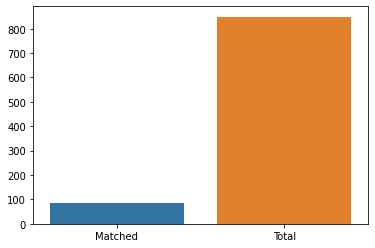

In [254]:
sns.barplot(x=['Matched', 'Total'], y=[86, 849])

## Count of matching Restaurants Across Cities

In [97]:
cities = [key for key in rest_counts.keys()]

In [98]:
num_of_restaurants = [value for value in rest_counts.values()]

<IPython.core.display.Javascript object>

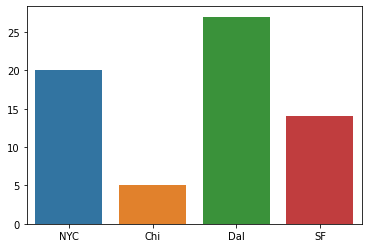

In [99]:
sns.barplot(x = cities, y = num_of_restaurants)

## Most Diverse Mexican Population

In [240]:
all_df.City.unique()

array(['Chicago', 'Dallas', 'SF', 'NYC'], dtype=object)

In [241]:
all_df.head(2)

,City,Match,Region
chilango,Chicago,chilango,Ciudad de Mexico
los alamos,Chicago,alamos,Tabasco


In [257]:
nunique_regions = all_df.groupby(['City']).Region.nunique()

In [258]:
nunique_restaurants = all_df.groupby(['City']).Region.count()

In [263]:
list(nunique_regions)

[5, 28, 21, 14]

In [277]:
list(nunique_restaurants)

[6, 140, 86, 45]

In [269]:
nunique_regions.keys()

Index(['Chicago', 'Dallas', 'NYC', 'SF'], dtype='object', name='City')

In [274]:
pct_unique = np.array(list(nunique_regions)) / np.array(list(nunique_restaurants))

In [266]:
pct_unique

array([0.83333333, 0.2       , 0.24418605, 0.31111111])

In [270]:
pct_unique_dict = dict(zip(nunique_regions.keys(), pct_unique))

In [271]:
pct_unique_dict

{'Chicago': 0.8333333333333334,
 'Dallas': 0.2,
 'NYC': 0.2441860465116279,
 'SF': 0.3111111111111111}

### Saving Diversity of Restaurants Dict

In [276]:
# with open ('./my_saved_data/restaurant_region_diversity.pickle', 'wb+') as f:
#     pickle.dump(pct_unique_dict, f)

# Statistical Analyses
is the proportion of people from Puebla in NYC larger than that in the other cities measured here?
https://www.pythonfordatascience.org/anova-python/

## Which Regions are uniquely represented within the 4 cities?

In [ ]:
model = ols('NYC ~ C(dose)', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

In [115]:
pct_df.head(2)

,index,NYC,Chi,Dal,SF
0,Aguascalientes,0.01,0.0,0.00,0.00
1,Baja California,0.07,0.0,0.02,0.04


In [114]:
stats.f_oneway(pct_df['NYC'],
               pct_df['Chi'],
              pct_df['Dal'],
              pct_df['SF'])

F_onewayResult(statistic=0.028040057224606556, pvalue=0.9936344283118124)

### Melting pct_df

In [123]:
pct_df_melt = pd.melt(pct_df.reset_index(), id_vars=['index'], value_vars=["NYC", "Chi", 'Dal', "SF"])
# replace column names
pct_df_melt.columns = ['index', 'treatments', 'value']

<IPython.core.display.Javascript object>

In [125]:
pct_df_melt.head(2)

,index,treatments,value
0,Aguascalientes,NYC,0.01
1,Baja California,NYC,0.07


### Post hoc Analysis

In [133]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=pct_df_melt['value'], groups=pct_df_melt['treatments'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   Chi    Dal   0.0045   0.9 -0.0408 0.0498  False
   Chi    NYC   0.0034   0.9 -0.0419 0.0488  False
   Chi     SF   0.0041   0.9 -0.0412 0.0494  False
   Dal    NYC   -0.001   0.9 -0.0463 0.0443  False
   Dal     SF  -0.0003   0.9 -0.0457  0.045  False
   NYC     SF   0.0007   0.9 -0.0446  0.046  False
--------------------------------------------------


# Conclusions

All 4 cities have large Mexican immigrant populations (250k and above according to: https://247wallst.com/economy/2017/01/27/us-cities-with-the-most-mexican-immigrants/). Despite this surface similarity, it turns out that these immigrants do not all come from similar regions in Mexico. No region was in the top 5 most popular region for more than 2 of these cities. This suggests that immigration from Mexico was not dominated by one region but came from all regions of Mexico. Similarly, we see that there are no single region that makes up the majority of any US city's Mexican population: in all cases, no region accounted for more than 36% of the restaurants with regions associated with their names. This did have some variation, however: in San Francisco Guanajuato accounts for 40% of the restaurants while in Dallas the most dominant group accounts for 21%.

Some shortcomings of this project are the quality of this data: both for the demonym dictionary and the inspection data. The demonym dictionary had many entries, but there were some clear errors, e.g.: the restaurant 'jalisco' in Dallas was associated with "Ciudad de Mexico" instead of the region Jalisco. Additionally, it is not clear if **all** restaurants in each city are included in this data, or only restaurants that failed the inspection. In a similar vein, some cities had data that had too low of a quality to be useful (LA). Another problem with this project is deciding when a "match" is legitimate. For example, "Pueblito" ("little town") appeared often and is a town in Queretáro, but do these restaurants refer to the former or the latter? This was decided on an ad hoc basis and was founded solely on my (non-native) discretion. Lastly, the obvious issue of immediate representation being a marker of the true number of people from a certain region is certainly flawed. Just because there are say, a lot of Italian restaurants in a certain area, does not necessarily mean that there are many italian (recent) immigrants to that area. The popularity of food from certain regions may skew the data. 

Anecdotally, it appears that chain migration happens at a micro level. "Tulcingo" appears 5 times in the NYC data despite the fact that the town that it refers to in Mexico, Tulcingo del Valle, has only 9,000 people living in it (source: https://es.wikipedia.org/wiki/Municipio_de_Tulcingo)! 